In [1]:
import pymysql
from sklearn.linear_model import ElasticNet,Lasso,Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.externals import joblib
connect = pymysql.connect(host='rr-bp1g814zgqeptx52q.mysql.rds.aliyuncs.com',user = 'qkids_stats',password='Stats$qkids', db='jiuqu_schedule_api', charset='utf8')
cur = connect.cursor()
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qkidsweeklessonmodel import QkidsLessonModel

#### week

In [2]:
sql = "select lesson_id, sum(r.msc), sum(r.sc)\
    from schedules s\
    inner join (\
    select schedule_id, sum(max_student_count) msc, sum(student_count) sc from rooms\
    where status = 1 group by schedule_id \
    ) r on r.schedule_id = s.id\
    where date_format(begin_at, '%%x-%%v') = '%s' and room_type_id in (1,2, 5) and is_internal = 0\
    group by lesson_id order by lesson_id;"
date = '2018-19'
cur.execute(sql % date)
raw_data = cur.fetchall()
# mymodel = QkidsLessonModel(('2018-18', '2018-19'))
# mymodel.init(date)

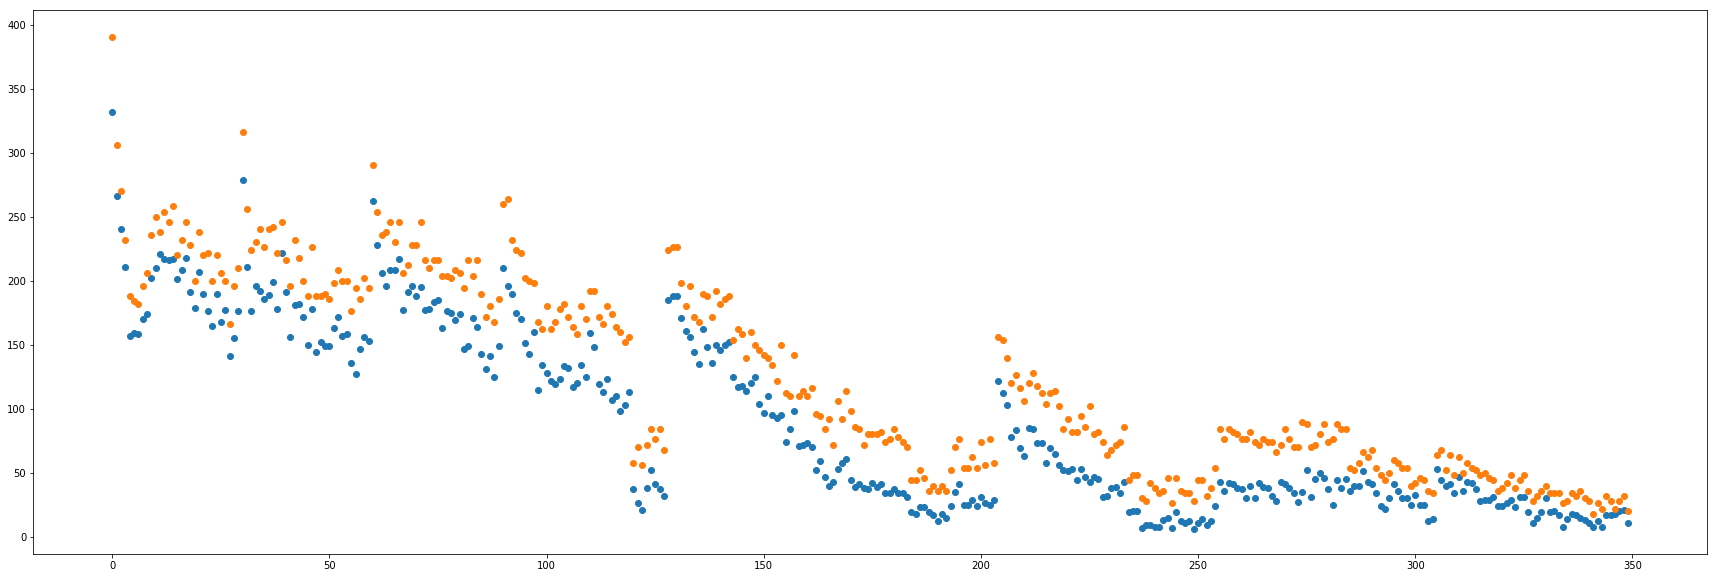

In [3]:
data = raw_data[0:350]
#X = np.array([i[0] for i in data ])
X = np.array(list(range(len(data))))
y = np.array([int(i[2]) for i in data ])
ym = np.array([int(i[1]) for i in data ])
plt.figure(figsize=(30, 10))
plt.scatter(X,y,label="actual")
plt.scatter(X,ym,label="max")
plt.scatter(X,ym,label="max")
#Yp = np.array(mymodel.predictAll(X))
# plt.plot(X,Yp, label='predict')
plt.show()

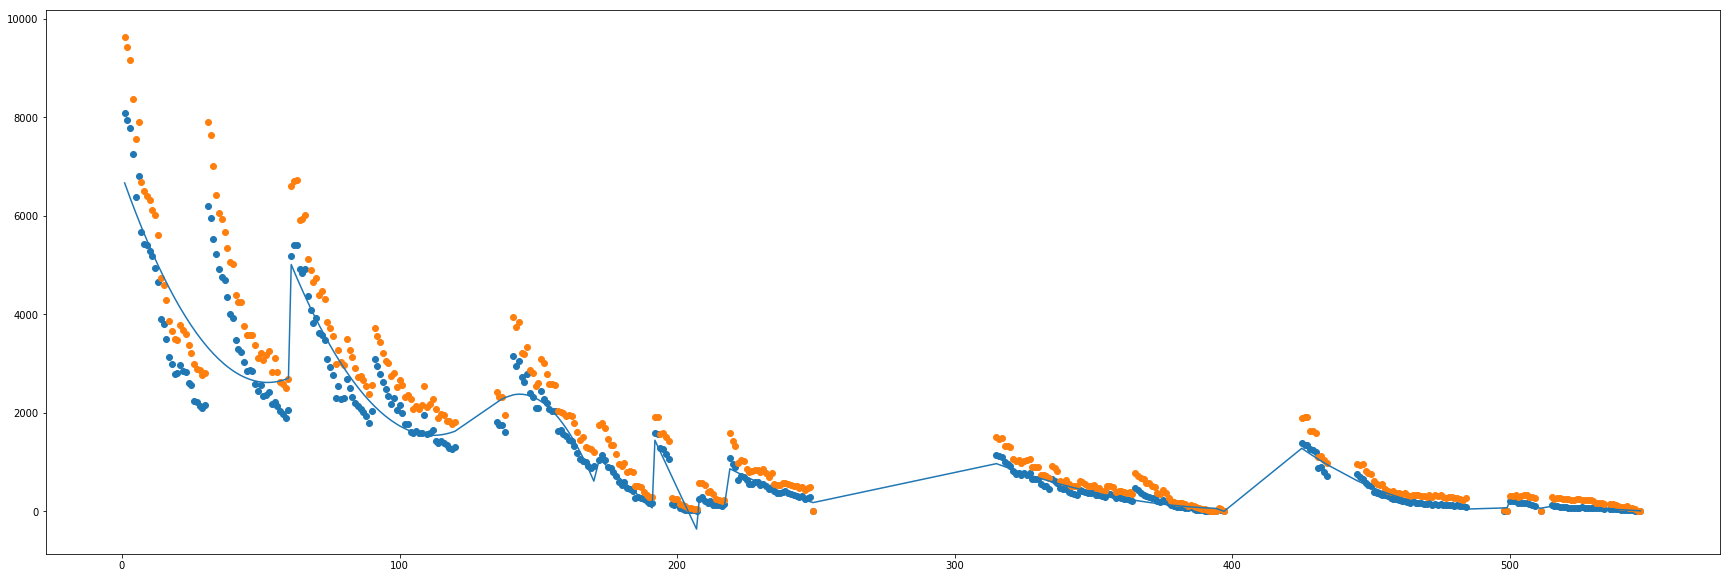

In [2]:
sql = "select lesson_id, sum(r.msc), sum(r.sc)\
    from schedules s\
    inner join (\
    select schedule_id, sum(max_student_count) msc, sum(student_count) sc from rooms\
    where status = 1 group by schedule_id \
    ) r on r.schedule_id = s.id\
    where begin_at > %r and room_type_id in (1,2,5) and is_internal = 0\
    group by lesson_id;"
date = '2018-02-01 00:00:00'
# cur.execute(sql % date)
# raw_data = cur.fetchall()
mymodel = QkidsLessonModel()
mymodel.init(date)
data = mymodel.raw_data
X = np.array([i[0] for i in data ])
y = np.array([int(i[2]) for i in data ])
ym = np.array([int(i[1]) for i in data ])
plt.figure(figsize=(30, 10))
plt.scatter(X,y,label="actual")
plt.scatter(X,ym,label="max")
Yp = np.array(mymodel.predictAll(X))
plt.plot(X,Yp, label='predict')
plt.show()

#### lesson(1,60)  独立拟合

In [4]:
from sklearn.linear_model import Ridge
interval = (0,350)
course_1 = X[interval[0]:interval[1]]
course_1_y = y[interval[0]:interval[1]]

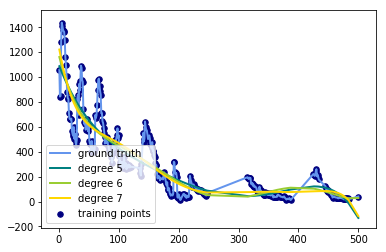

In [5]:
# create matrix versions of these arrays
XX = course_1[:, np.newaxis]
X_plot = course_1[:, np.newaxis]


colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(course_1, course_1_y, color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(course_1, course_1_y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5, 6, 7]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(XX, course_1_y)
    y_plot = model.predict(X_plot)
    plt.plot(X_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

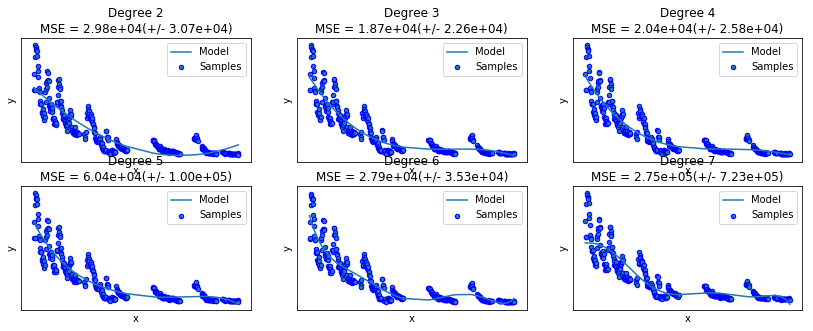

In [6]:
degrees = [ 2, 3, 4, 5 , 6, 7]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(2, 3, i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
   
    #joblib.dump(pipeline, 'sch_%d.pkl' % i)
    #clf = joblib.load('filename.pkl') 
    if degrees[i] == 5:
        joblib.dump(pipeline, 'model/model_%s.pkl' % date)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 160)
    plt.plot(X, pipeline.predict(X[:, np.newaxis]), label="Model")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

In [7]:
days = np.array([13192,13362,13759, 14105, 12528,12610, 11707])
slots = np.array([1852, 2444, 2402, 2320, 2099, 16126, 21408, 22663, 19949])

In [8]:
total = (np.sum(days)+ np.sum(slots)) / 2
model = np.dot(slots.reshape(9,-1)/total, days.reshape(1,7)/total)

In [9]:
output = np.array([200* model, 234*model])
output

array([[[ 0.58666765,  0.5942278 ,  0.61188297,  0.6272701 ,  0.55713859,
          0.56078525,  0.52062751],
        [ 0.77419856,  0.78417534,  0.80747407,  0.82777977,  0.73523041,
          0.74004274,  0.6870484 ],
        [ 0.760894  ,  0.77069934,  0.79359768,  0.81355442,  0.72259552,
          0.72732515,  0.67524151],
        [ 0.73491844,  0.74438903,  0.76650567,  0.78578112,  0.69792739,
          0.70249556,  0.65218997],
        [ 0.66491112,  0.67347956,  0.69348939,  0.71092869,  0.63144379,
          0.6355768 ,  0.59006326],
        [ 5.10831667,  5.1741455 ,  5.32787516,  5.46185618,  4.85119704,
          4.88294976,  4.53328254],
        [ 6.78152321,  6.86891398,  7.07299711,  7.25086302,  6.44018518,
          6.48233837,  6.0181392 ],
        [ 7.17907607,  7.27158994,  7.48763703,  7.67592996,  6.81772779,
          6.86235213,  6.37094024],
        [ 6.31934822,  6.40078312,  6.59095756,  6.75670153,  6.00127308,
          6.04055344,  5.60799042]],

       [

##### MODEL

In [10]:
np.arange(63).reshape(9,7)

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27],
       [28, 29, 30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39, 40, 41],
       [42, 43, 44, 45, 46, 47, 48],
       [49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62]])

In [11]:
basemodel = np.array([54,62,55,56, 1,9, 17,25, 33,41,42, 50, 58, 3, 11, 19,27,28, 36, 44, 52, 60, 5, 13, 14, 22, 30, 38, 46, 39, 47,
        40, 48, 49,57,2,10,18,26,34,35,43,51,59,4,12,20,21,29,37,45,53,61,6,7,15,23,31,24,32,0,8,16])

#### 9*7 63slots 全排

In [12]:
l = list()
for i in basemodel:
    temp = np.zeros(63)
    temp[i] = 1
    l.append(temp.reshape(9,7))
unit = np.array(l)